<a href="https://colab.research.google.com/github/charan0506/human-_activity_cs725/blob/main/cs725project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from numpy import pi 

# To create plots
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt

# Aesthetic plots 
import seaborn as sns

# interactive plots 
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)


# To get new datatypes and functions
from collections import Counter
from cycler import cycler


# To investigate distributions
from scipy.stats import norm, skew, probplot
from scipy.optimize import curve_fit


# To build models
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# To gbm light
from lightgbm import LGBMClassifier

# To measure time
from time import time
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt

In [ ]:
train = shuffle(pd.read_csv("/content/drive/MyDrive/cs725project/archive/train.csv"))
test = shuffle(pd.read_csv("/content/drive/MyDrive/cs725project/archive/test.csv"))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


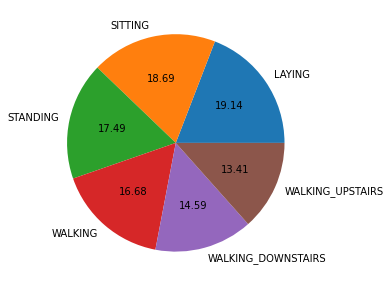

In [ ]:
X_train=train.iloc[:,:-2]
y_train=train.iloc[:,-1]

#X_test=test_data.iloc[:,:-2]
#y_test=test_data.iloc[:,-1]
Category_count=np.array(y_train.value_counts())
activity=sorted(y_train.unique())
plt.figure(figsize=(15,5))
plt.pie(Category_count,labels=activity,autopct = '%0.2f');
plt.savefig('foo.png')

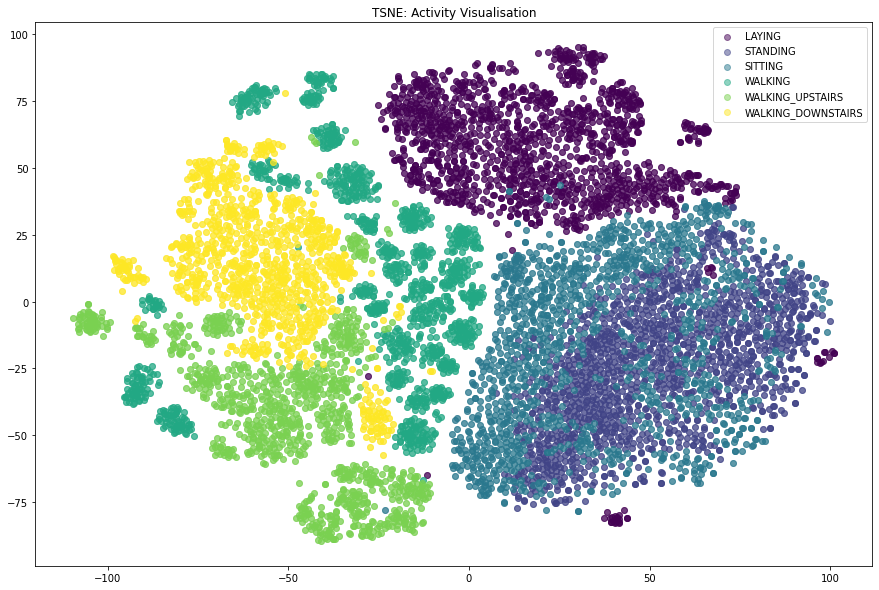

In [ ]:
# Load datasets
train_df = pd.read_csv("/content/drive/MyDrive/cs725project/archive/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/cs725project/archive/train.csv")


# Combine boths dataframes
train_df['Data'] = 'Train'
test_df['Data'] = 'Test'

both_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

both_df['subject'] = '#' + both_df['subject'].astype(str)

# Create label
label = both_df.pop('Activity')

#print('Shape Train:\t{}'.format(train_df.shape))
#print('Shape Test:\t{}\n'.format(test_df.shape))

#train_df.head()

pd.DataFrame.from_dict(Counter([col.split('-')[0].split('(')[0] for col in both_df.columns]),orient = "index").\
rename(columns={0:'count'}).sort_values('count', ascending=False)
label_counts = label.value_counts()

n = label_counts.shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Create plot
'''data = go.Bar(x = label_counts.index,
              y = label_counts,
              marker = dict(color = colors))

layout = go.Layout(title = 'Smartphone Activity Label Distribution',
                   xaxis = dict(title = 'Activity'),
                   yaxis = dict(title = 'Count'))


fig = go.Figure(data=[data], layout=layout)
iplot(fig)
plt.show()'''




tsne_data = both_df.copy()
data_data = tsne_data.pop('Data')
subject_data = tsne_data.pop('subject')

# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)


# Reduce dimensions (speed up)
pca = PCA(n_components=0.9, random_state=3)
tsne_data = pca.fit_transform(tsne_data)

# Transform data
tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(tsne_data)


# Create subplots
fig, axarr = plt.subplots(1, 1, figsize=(15,10))

# Get colors
n = label.unique().shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]


# Plot each activity
for i, group in enumerate(label_counts.index):
    # Mask to separate sets
    mask = (label==group).values
    axarr.scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)
axarr.set_title('TSNE: Activity Visualisation')
axarr.legend()
plt.savefig('foo.png')
plt.show()

In [ ]:
def knn_distances(xTrain,xTest,k=6):
    """
    Finds the k nearest neighbors of xTest in xTrain.
    Input:
    xTrain = n x d matrix. n=rows and d=features
    xTest = m x d matrix. m=rows and d=features (same amount of features as xTrain)
    k = number of nearest neighbors to be found
    Output:
    dists = distances between all xTrain and all XTest points. Size of n x m
    indices = k x m matrix with the indices of the yTrain labels that represent the point
    """
    #the following formula calculates the Euclidean distances.
    import numpy as np
    distances = -2 * xTrain@xTest.T + np.sum(xTest**2,axis=1) + np.sum(xTrain**2,axis=1)[:, np.newaxis]
    #because of float precision, some small numbers can become negatives. Need to be replace with 0.
    distances[distances < 0] = 0
    distances = distances**.5
    indices = np.argsort(distances, 0) #get indices of sorted items
    distances = np.sort(distances,0) #distances sorted in axis 0
    #returning the top-k closest distances.
    return indices[0:k,:], distances[0:k,:]



def knn_predictions(xTrain,yTrain,xTest,k=14):
    """
    Uses xTrain and yTrain to predict xTest.
    Input:
    xTrain = n x d matrix. n=rows and d=features
    yTrain = n x 1 array. n=rows with label value
    xTest = m x d matrix. m=rows and d=features (same amount of features as xTrain)
    k = number of nearest neighbors to be found
    Output:
    predictions = predicted labels, ie preds(i) is the predicted label of xTest(i,:)
    """
    import numpy as np
    indices, distances = knn_distances(xTrain,xTest,k)
    yTrain = yTrain.flatten()
    rows, columns = indices.shape
    predictions = list()
    for j in range(columns):
        temp = list()
        for i in range(rows):
            cell = indices[i][j]
            temp.append(yTrain[cell])
        predictions.append(max(temp,key=temp.count)) #this is the key function, brings the mode value
    predictions=np.array(predictions)
    return predictions


def knn_accuracy(yTest,predictions):
    """
    Evaluates accuracy of the knn_predictions. Returns a value between 0 and 100%.
    Input:
    yTest = array of shape (n,) where n = rows in test set
    preds = array of shape (n,) where n = rows in test set
    Output:
    accuracy = % of correct answers in the prediction
    """
    import numpy as np
    x=yTest.flatten()==predictions.flatten()
    grade=np.mean(x)
    return np.round(grade*100,2)

In [ ]:
# Seperating Predictors and Outcome values from train and test sets
X_train = pd.DataFrame(train.drop(['Activity','subject'],axis=1))
Y_train_label = train.Activity.values.astype(object)
X_test = pd.DataFrame(test.drop(['Activity','subject'],axis=1))
Y_test_label = test.Activity.values.astype(object)

In [ ]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()

encoder.fit(Y_train_label)
Y_train = encoder.transform(Y_train_label)

encoder.fit(Y_test_label)
Y_test = encoder.transform(Y_test_label)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#The knn_predictions function will call knn_distances and bring back prediction based
# on the distance and the size of k.
predictions = knn_predictions(X_train_scaled, Y_train, X_test_scaled,14)
print('Size of Predictions Array:\n', predictions.shape)
#print('\nPredictions Array:\n',knn_predictions(xTrain,yTrain,xTest,6))
#Will call knn_accuracy, which was imported from knn.py file
print('Accuracy:',knn_accuracy(predictions,Y_test),'%')

Size of Predictions Array:
 (2947,)
Accuracy: 89.24 %


In [ ]:
# K Nearest Neighbors using sklearn Algorithm for comparision.
clf = KNeighborsClassifier().fit(X_train_scaled,Y_train)
prediction = clf.predict(X_test_scaled)
accuracy_scores = accuracy_score(Y_test, prediction)*100
print('K Nearest Neighbors Classifier accuracy: {}%'.format(accuracy_scores))

K Nearest Neighbors Classifier accuracy: 88.36104513064133%


In [ ]:
# Dimension of Train and Test set 
print("Dimension of Train set",X_train.shape)
print("Dimension of Test set",X_test.shape,"\n")

# Transforming non numerical labels into numerical labels
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()

# encoding train labels 
encoder.fit(Y_train_label)
Y_train = encoder.transform(Y_train_label)

# encoding test labels 
encoder.fit(Y_test_label)
Y_test = encoder.transform(Y_test_label)

#Total Number of Continous and Categorical features in the training set
num_cols = X_train._get_numeric_data().columns
#print("Number of numeric features:",num_cols)
#list(set(X_train.columns) - set(num_cols))


names_of_predictors = list(X_train.columns.values)

# Scaling the Train and Test feature set 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Dimension of Train set (7352, 561)
Dimension of Test set (2947, 561) 



In [ ]:
#Libraries to Build Ensemble Model : Random Forest Classifier 
# Create the parameter grid based on the results of random search 
def SVM_Model():
  params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
  svm_model = GridSearchCV(SVC(), params_grid, cv=5)
  svm_model.fit(X_train_scaled, Y_train)
  # View the accuracy score
  print('Best score for training data:', svm_model.best_score_,"\n") 
  # View the best parameters for the model found using grid search
  print('Best C:',svm_model.best_estimator_.C,"\n") 
  print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
  print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")
  final_model = svm_model.best_estimator_
  Y_pred = final_model.predict(X_test_scaled)
  Y_pred_label = list(encoder.inverse_transform(Y_pred))
  # Making the Confusion Matrix
  #print(pd.crosstab(Y_test_label, Y_pred_label, rownames=['Actual Activity'], colnames=['Predicted Activity']))
  print(confusion_matrix(Y_test_label,Y_pred_label))
  print("\n")
  print(classification_report(Y_test_label,Y_pred_label))
  print("Training set score for SVM: %f" % final_model.score(X_train_scaled , Y_train))
  print("Testing  set score for SVM: %f" % final_model.score(X_test_scaled  , Y_test ))
  svm_model.score

In [ ]:
SVM_Model()

Best score for training data: 0.9876224697900915 

Best C: 1000 

Best Kernel: rbf 

Best Gamma: 0.001 

[[537   0   0   0   0   0]
 [  3 439  48   0   0   1]
 [  0  11 521   0   0   0]
 [  0   0   0 486   4   6]
 [  0   0   0   6 389  25]
 [  0   0   0  15   2 454]]


                    precision    recall  f1-score   support

            LAYING       0.99      1.00      1.00       537
           SITTING       0.98      0.89      0.93       491
          STANDING       0.92      0.98      0.95       532
           WALKING       0.96      0.98      0.97       496
WALKING_DOWNSTAIRS       0.98      0.93      0.95       420
  WALKING_UPSTAIRS       0.93      0.96      0.95       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947

Training set score for SVM: 1.000000
Testing  set score for SVM: 0.958941
